In [14]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [39]:
hallmark = pd.read_excel('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/FW__MCF10A_wild_type_and_PIK3CA_H1047R_knock-in_cell_lines/Supplementary Table S4.xlsx', 
    sheet_name='MCF10A_hallmark_PI3K_Inhibition')

In [96]:
hallmark.to_csv('hallmark.csv', index=None)

In [6]:
hallmark = hallmark[['Description', 'core_enrichment']]

In [8]:
from utils import Data, get_ppi_edge_list

data_csv = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

In [19]:
ppi = pd.DataFrame(get_ppi_edge_list(sparse=False)[:, :2], columns=['A', 'B'])

(utils.py : 456) -    DEBUG | Loaded 352251 edges from the SIGNOR and SNAP Networks


,A,B
0,GOLGA7,HRAS
1,GOLGA7,ZDHHC9
2,ARHGAP22,CDC42
3,ARHGAP22,RHOA
4,ARHGAP22,RAC1
...,...,...
352246,PCSK5,LCE3D
352247,ICE2,LTF
352248,CDO1,GAD2
352249,H2BC8,CCDC25


In [55]:
tf_ppi = ppi[ppi.A.isin(data_csv.tf) | ppi.B.isin(data_csv.tf)]

In [80]:
tfs = pd.DataFrame(data_csv.tf)
tfs.columns = ['tf']
tfs

,tf
0,CDC5L
1,PPARG
2,HOXB8
3,NFATC1
4,OVOL1
...,...
315,HMBOX1
316,FUBP1
317,ZNF740
318,CEBPZ


In [83]:
tfs['interacts_with'] = tfs.tf.apply(lambda x: set(tf_ppi[(tf_ppi==x).any(axis=1)].values.reshape(-1)))

In [93]:
tfs = dict(zip(tfs['tf'], tfs['interacts_with']))

In [101]:
def does_interact(tf, geneset):
    if tf in geneset or len(tfs.get(tf, set()).intersection(geneset)) > 0:
        return True            
    return False

In [102]:
pbar = tqdm(total=len(hallmark.values))
hallmark_mask = np.zeros((hallmark.shape[0], len(data_csv.tf)), dtype=int)

for idx, (pathway, genes) in enumerate(hallmark.values):
    for idy, tf in enumerate(data_csv.tf):
        pbar.set_description(f'{pathway[9:]} | ({idy}/{len(data_csv.tf)}) - {tf}')
        if does_interact(tf, genes.split('/')):
            hallmark_mask[idx, idy] = 1
    
    pbar.update(1)
pbar.close()

np.save('hallmark_mask.npy', hallmark_mask)

  0%|          | 0/50 [00:00<?, ?it/s]

In [112]:
pd.DataFrame(hallmark_mask, index=hallmark.Description, columns=data_csv.tf).sum(0).sort_values(ascending=False)[:15]

TP53     45
MYC      44
SMAD3    44
ESR1     44
STAT3    41
RELA     40
NR3C1    40
SMAD2    40
AR       39
JUN      39
BRCA1    39
CREB1    36
FOXO3    35
YBX1     35
SMAD4    34
dtype: int64

In [113]:
pd.DataFrame(hallmark_mask, index=hallmark.Description, columns=data_csv.tf).sum(1).sort_values(ascending=False)[:15]

Description
HALLMARK_APOPTOSIS                    166
HALLMARK_G2M_CHECKPOINT               164
HALLMARK_MYC_TARGETS_V1               150
HALLMARK_PI3K_AKT_MTOR_SIGNALING      141
HALLMARK_E2F_TARGETS                  136
HALLMARK_TNFA_SIGNALING_VIA_NFKB      136
HALLMARK_P53_PATHWAY                  129
HALLMARK_MYOGENESIS                   118
HALLMARK_HEME_METABOLISM              117
HALLMARK_UV_RESPONSE_DN               116
HALLMARK_MTORC1_SIGNALING             107
HALLMARK_HYPOXIA                      103
HALLMARK_IL2_STAT5_SIGNALING           98
HALLMARK_ALLOGRAFT_REJECTION           97
HALLMARK_UNFOLDED_PROTEIN_RESPONSE     96
dtype: int64

In [29]:
import os
import argparse
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations
from models import CITRUS
import pickle
import torch
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore") ##This is bad but temporary

import yaml

with open('args.yaml', 'r') as f:
    args_dict = yaml.safe_load(f)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    device_name = torch.cuda.get_device_name(0)
else:
    device_name = 'cpu'


parser = argparse.ArgumentParser()
args = argparse.Namespace(**args_dict)
args.tf_gene = np.load('tf_gene.npy')

In [30]:
dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)

train_set, test_set = split_dataset(dataset, ratio=0.66)

# args.can_size = dataset["can"].max()  # cancer type dimension
# args.sga_size = dataset["sga"].max()  # SGA dimension
# args.gep_size = dataset["gep"].shape[1]  # GEP output dimension
# args.num_max_sga = dataset["sga"].shape[1]  # maximum number of SGAs in a tumor

# args.hidden_size = dataset["tf_gene"].shape[0]
# # args.tf_gene = dataset["tf_gene"]


model = CITRUS(args)  # initialize CITRUS model
model.build(device=device)  # build CITRUS model
model.to(device);

In [15]:
# with open('args.yaml', 'w') as f:
#     yaml.dump(vars(args), f, default_flow_style=False)

In [31]:
model.load_state_dict(torch.load(f'/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output/model_4.pth', 
                    map_location=torch.device('cpu')))
model.eval()

CITRUS(
  (layer_sga_emb): Embedding(11999, 256, padding_idx=0)
  (layer_can_emb): Embedding(18, 256, padding_idx=0)
  (layer_w_0): Linear(in_features=256, out_features=256, bias=True)
  (layer_beta): Linear(in_features=256, out_features=16, bias=True)
  (layer_dropout_1): Dropout(p=0.2, inplace=False)
  (layer_dropout_2): Dropout(p=0.2, inplace=False)
  (layer_w_1): Linear(in_features=256, out_features=50, bias=True)
  (bnorm_pathways): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pathways): Linear(in_features=50, out_features=320, bias=True)
  (bnorm_tf): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_w_2): Linear(in_features=320, out_features=5541, bias=True)
  (loss): MSELoss()
)

In [36]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients
from scipy.stats import ttest_ind

In [48]:
model.pathways.weight.shape

torch.Size([320, 50])

In [32]:
from utils import Data
from utils import get_ppi_edge_list

data = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

d = data.cancerType_sga.loc[dataset['tmr']]
d['index'] = dataset['can'].reshape(-1)

xdf = pd.DataFrame(enumerate(dataset['tmr']))
xdf.columns = ['idx', 'id']

brca = pd.DataFrame(data.sga_sga.loc[data.cancerType_sga[data.cancerType_sga['type']=='BRCA'].index])
# brca = pd.DataFrame(data.sga_sga.loc[data.cancerType_sga.index])

is_mutated_gene = 'PIK3CA'

wt = brca[(brca[f'SM_{is_mutated_gene}'] == 0) & (brca[f'SCNA_{is_mutated_gene}'] == 0)]
sm_mut = brca[(brca[f'SM_{is_mutated_gene}'] == 1) & (brca[f'SCNA_{is_mutated_gene}'] == 0)]
scna_mut = brca[(brca[f'SM_{is_mutated_gene}'] == 0) & (brca[f'SCNA_{is_mutated_gene}'] == 1)]
sm_scna_mut = brca[(brca[f'SM_{is_mutated_gene}'] == 1) & (brca[f'SCNA_{is_mutated_gene}'] == 1)]
wt.shape, sm_mut.shape, scna_mut.shape, sm_scna_mut.shape

((435, 11998), (253, 11998), (20, 11998), (12, 11998))

In [33]:
idx = xdf[xdf.id.isin(wt.index)].idx.values
X = torch.from_numpy(dataset['sga'])[idx]
C = torch.from_numpy(dataset['can'][idx])
r = model(X, C, pathways=True).data.numpy()

In [34]:
idx = xdf[xdf.id.isin(sm_mut.index)].idx.values
X = torch.from_numpy(dataset['sga'])[idx]
C = torch.from_numpy(dataset['can'][idx])
s = model(X, C, pathways=True).data.numpy()

In [40]:
p_predicted = pd.DataFrame(ttest_ind(r, s).pvalue, 
        index=hallmark.Description, 
        columns=['pvalue']).sort_values(by='pvalue', ascending=True).loc[hallmark.Description].pvalue.values

In [41]:
p_exp = hallmark['pvalue'].values

In [42]:
import seaborn as sns

<AxesSubplot:>

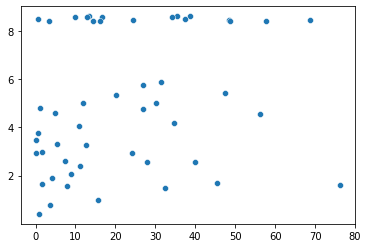

In [44]:
sns.scatterplot(-np.log(p_predicted), -np.log(p_exp))

In [82]:
from scipy.stats import spearmanr

In [ ]:
M = model
M.analysis_mode = True
lc = LayerConductance(M, M.pathways)

results = []
AA = []

for frame, name in zip([wt, sm_mut, scna_mut, sm_scna_mut], ['WT', 'SM', 'SCNA', 'SM_SCNA']):
    if len(frame) == 0:
        break
    scores = []

    idx = xdf[xdf.id.isin(frame.index)].idx.values
    X = torch.from_numpy(dataset['sga'])

    # G = [i for i in data.gene_tf_sga.index if 'AKT' in i] + [i for i in data.gene_tf_sga.index if 'PIK' in i]
    # G = ['PIK3CA']
    # G = [i for i in data.gene_tf_sga.index if 'AKT' in i]
    # G = [i for i in data.gene_tf_sga.index if 'PIK' in i]
    
    # G = ['AKT1', 'PIK3CA', 'AKT2']
    
    G = ['NFE2L2']
    
    # G = merged2['PI3K/AKT Signaling in Cancer']
    
    # G = ['AKT1']

    for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
        a = lc.attribute((X[idx], torch.from_numpy(dataset['can'][idx])), n_steps=5, 
                        attribute_to_layer_input=True, target=[ix]*len(X[idx]))
        ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
        ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
        scores.append(ig_attr_test_norm_sum)
        
    AA.append(a)
    g = np.array(_pathways[2])
    at = np.sum(scores, 0)

    assert g.shape == at.shape

    df = pd.DataFrame([g, at]).T
    df.columns = ['Pathways', f'score_{name}']
    results.append(df.set_index('Pathways'))
    
AA = np.array([i.detach().numpy() for i in AA])